In [1]:
%matplotlib inline
import pandas as pd
# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

I will be following along [the example here](https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64), shown in [the notebook here](https://github.com/WillKoehrsen/taxi-fare/blob/master/A%20Walkthrough%20and%20a%20Challenge.ipynb).

That being said, I will be handling things slightly differently, esp. w/r/t layout and plotting of the data.

As in the example:

Throughout this notebook, we will work with only 5 million rows (out of 55 million). The first point for improvement might therefore be to use more data!

Generally, performance of a machine learning model increases as the amount of training data increases. However, there might be diminishing returns, and I sample the data here in order to train faster. The data file is randomly sorted by date, so taking the first 5 million rows is a random sample in terms of time.
When we read in the data, we tell pandas to treat the pickup_datetime as a date. We will also drop the key since it is a unique identifier and does not tell us anything about the taxi trip. After reading in the data we'll remove any rows with nan (observations with missing entries).

In [2]:
import time
import os
start_time = time.time()
if not os.path.exists('store.h5'):
# load the data
    data = pd.read_csv('input/train.csv', nrows=5_000_000,
        parse_dates = ['pickup_datetime']).drop(columns='key')
    # remove na
    ## I am not sure what na means
    data = data.dropna()
    with pd.HDFStore('store.h5') as store:
        store['df'] = data
    ## I am not sure what head does either
    data.head()
else:
    with pd.HDFStore('store.h5') as store:
        data = store['df']
stop_time = time.time()
print(stop_time - start_time)

484.0354630947113


## Describe Data

An effective method for catching outliers and anomalies is to find the summary statistics for the data using the .describe() method. I like to concentrate on the maxes and the minimums for finding outliers.

In [4]:
data.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  4999964.000       4999964.000      4999964.000        4999964.000   
mean        11.341           -72.507           39.920            -72.507   
std          9.820            12.810            8.963             12.848   
min       -100.000         -3426.609        -3488.080          -3412.653   
25%          6.000           -73.992           40.735            -73.991   
50%          8.500           -73.982           40.753            -73.980   
75%         12.500           -73.967           40.767            -73.964   
max       1273.310          3439.426         3310.364           3457.622   

       dropoff_latitude  passenger_count  
count       4999964.000      4999964.000  
mean             39.917            1.685  
std               9.487            1.332  
min           -3488.080            0.000  
25%              40.734            1.000  
50%              40.753            1.000  
75%              40.768            2.000  
max            3345.917          208.000

Observations:

- pickup_longitude has both suspicious min and max values
- pickup_latitude has both suspicious min and max values
- same for both dropoffs
- the passenger count of 208 is very strange and not real
- passenger count of 0 is...possible fine, but again, should be suspicious
- a negative fare makes very little sense

# Remember the goal

Predict the fare based on other variables

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


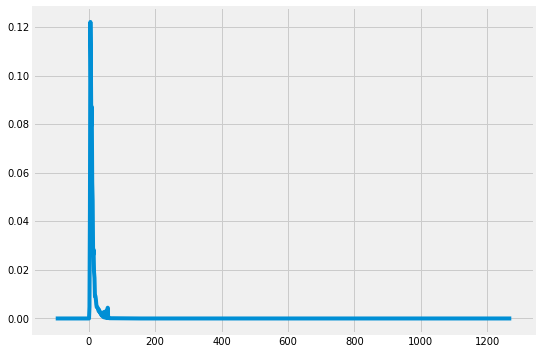

In [5]:
# screw seaborn, we're mpl purists here
y, bin_edges = np.histogram(data['fare_amount'], bins=1000, normed=True)
x = (bin_edges[1:] - bin_edges[:-1]) / 2 + bin_edges[:-1]
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x, y)
plt.show()

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


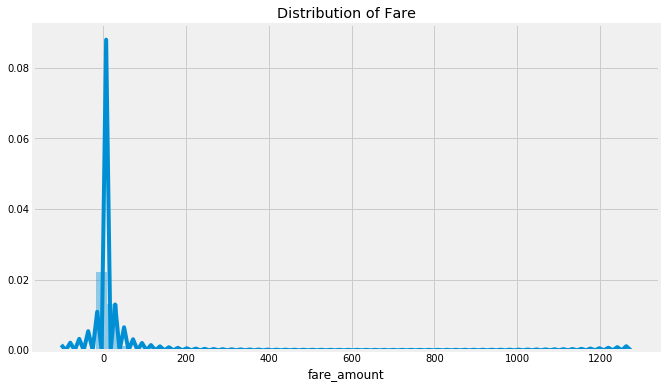

In [6]:
import seaborn as sns
palette = sns.color_palette('Paired', 10)
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount']);
plt.title('Distribution of Fare');

ok, fine, it looks like Seaborn isn't too bad...

I also learned about f-strings today:

In [7]:
print(f"There are {len(data[data['fare_amount'] < 0])} negative fares.")
print(f"There are {len(data[data['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(data[data['fare_amount'] > 100])} fares greater than $100.")

There are 211 negative fares.
There are 132 $0 fares.
There are 1977 fares greater than $100.


From the exercise/example, we assume that any "real" fare must be $\$2.50 < f < \$100$.

### Note:

*changing these bounds* will *affect the model and may improve the model*

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


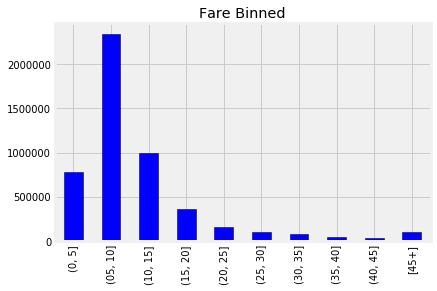

In [8]:
# I will be using `clean_data` rather than data since it takes a long time to re-load the data
clean_data = data[data['fare_amount'].between(left=2.5, right=100)]

# and create a binned version to visualize

# Bin the fare and convert to string
## appears to add a field called 'fare-bin'
## appears to 'cut' the data into bins by every $5
## makes this a string...why a string?
clean_data['fare-bin'] = pd.cut(clean_data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
clean_data.loc[clean_data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
clean_data.loc[clean_data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
clean_data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

Warnings and formatting aside, the distribution is clearly right-skewed.

Now consider the [empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function)

In [9]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

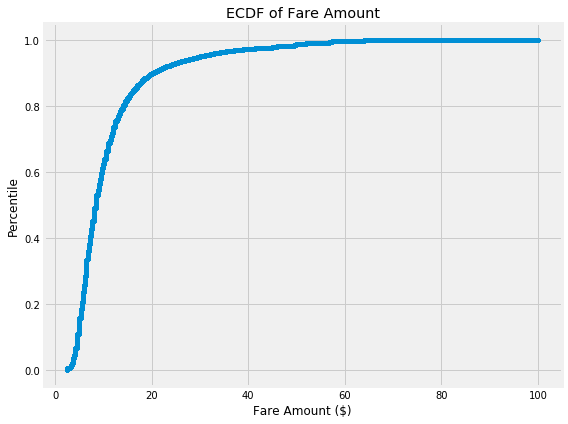

In [10]:
xs, ys = ecdf(clean_data['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');
plt.tight_layout()

Again, heavily right-skewed (~90% of the values are below \\$20)

## Finding other outliers

What about strange passenger counts?

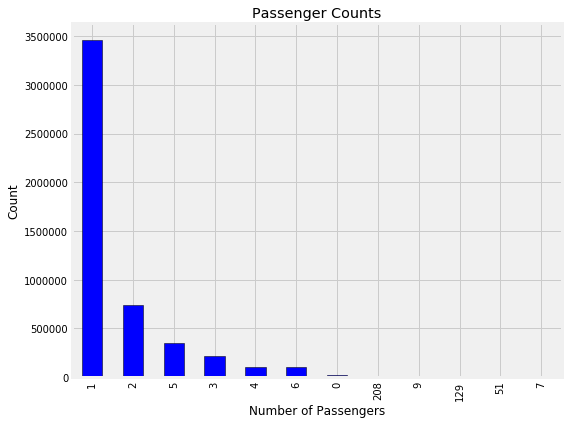

In [11]:
# note I am doing this with the un-clean data first
plt.figure(figsize = (8, 6))
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');
plt.tight_layout()
plt.show()

Clearly, there are some strange values...remove anything more than 6 as that seems insignificant...9 could be real, but unlikely

In [12]:
clean_data = clean_data.loc[clean_data['passenger_count'] < 6]

For the latitude and longitude columns, we can use statistics as well as our intuition for removing outliers. Here I'll find the 2.5% and 97.5% percentile values in each column and keep only measurements close to that range.

In [13]:
print(f'Initial Observations: {clean_data.shape[0]}')

Initial Observations: 4891807


In [14]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(clean_data[col], 2.5), 2):5} \t 97.5% = {round(np.percentile(clean_data[col], 97.5), 2)}')

Pickup_latitude  : 2.5% = 40.64 	 97.5% = 40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% = -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% = 40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% = -73.78


Based on these values, we can remove outliers. This is somewhat based on intuition and there might be a more accurate process for carrying out this operation! Here is another potential point for improvement:
- **Potential improvement 2: experiment with different methods to remove outliers.** This could be through domain knowledge (such as using a map) or it could be using more rigorous statistical methods (such as z-scores).

In [15]:
# Remove latitude and longtiude outliers
clean_data = clean_data.loc[clean_data['pickup_latitude'].between(40, 42)]
clean_data = clean_data.loc[clean_data['pickup_longitude'].between(-75, -72)]
clean_data = clean_data.loc[clean_data['dropoff_latitude'].between(40, 42)]
clean_data = clean_data.loc[clean_data['dropoff_longitude'].between(-75, -72)]

print(f'New number of observations: {clean_data.shape[0]}')

New number of observations: 4789046


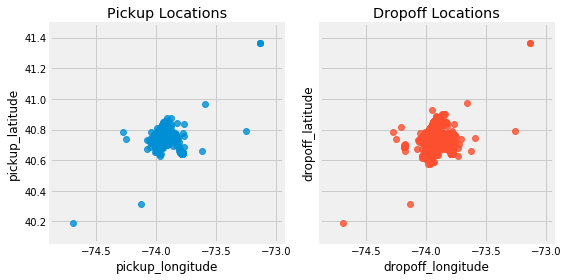

In [16]:
# Set random seed 
RSEED = 100

fig, axes = plt.subplots(1, 2, figsize = (8, 4), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = clean_data.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = clean_data.sample(10000, random_state = RSEED), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');
plt.tight_layout()
plt.show()

Let's do something really cool and plot this all on a map of NYC!


In [17]:
# load image of NYC map
# BB = (-74.5, -72.8, 40.5, 41.8)
# nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

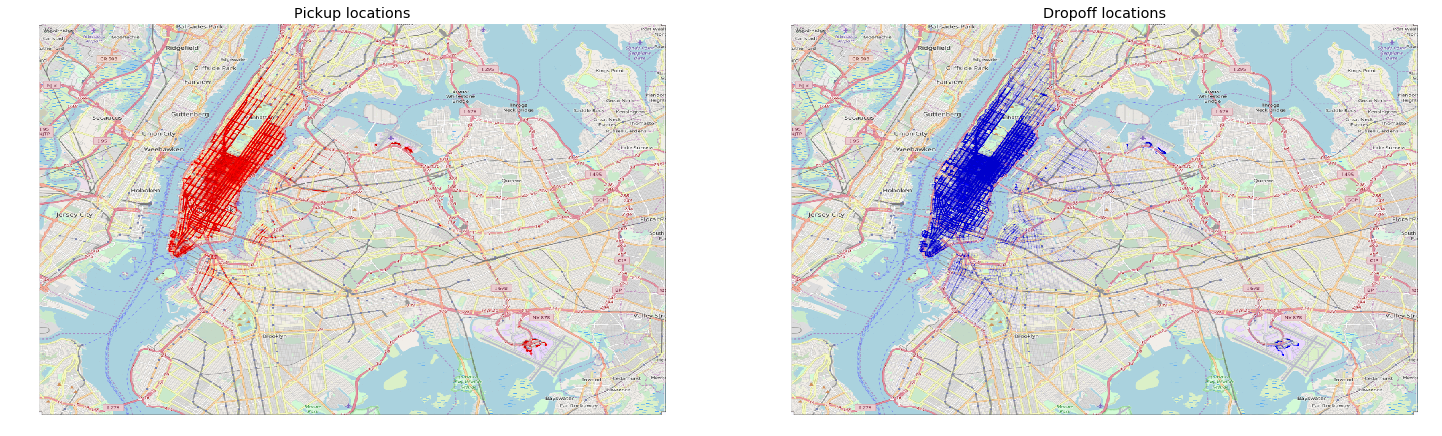

In [18]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(22, 18))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
#     plt.tight_layout()
    
# plot training data on map zoomed in
plot_on_map(clean_data.sample(1_000_000, random_state = RSEED), 
            BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

That is pretty neat (I do need to dig farther into the code to see how he did it)

Now plot based on the fare bin:

In [19]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(clean_data['fare-bin'].unique())}
clean_data['color'] = clean_data['fare-bin'].map(color_mapping)
plot_data = clean_data.sample(1_000_000, random_state=RSEED)

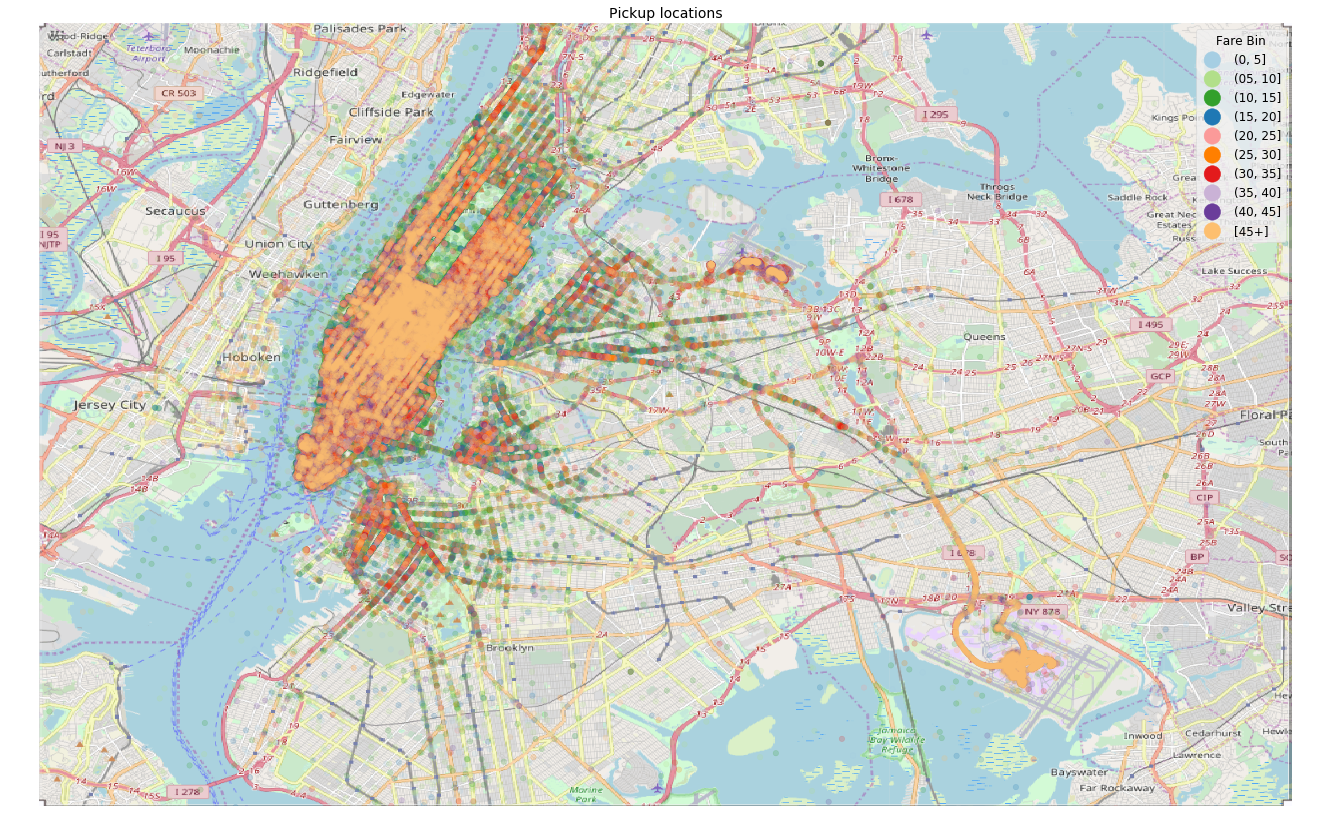

In [20]:
BB = BB_zoom

fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_data.groupby('fare-bin'):
    # Set the zorder to 1 to plot on top of map
    axs.scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Pickup locations', size = 14)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 12, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 12})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

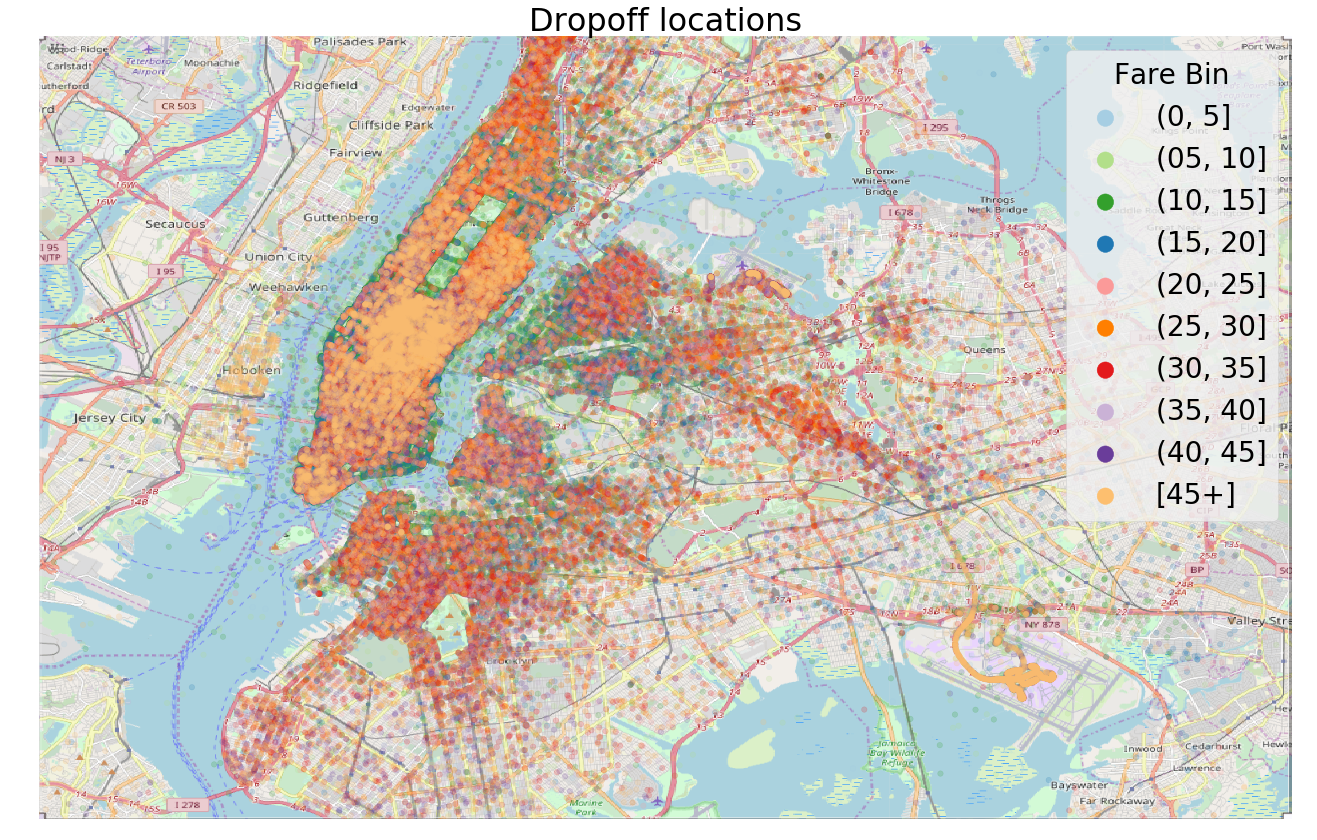

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_data.groupby('fare-bin'):
    axs.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, 
                alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Dropoff locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

# Feature Engineering

Feature engineering is the process of creating features - predictor variables - out of a dataset. **Feature engineering is the most important step of the machine learning pipeline** (A Few Useful Things to Know about Machine Learning). A model can only learn from the features it is given, and properly constructing features will determine how well your model performs.

Feature engineering involves domain expertise and experience on prior machine learning projects. A good place to start for Kaggle competitions is other kernels. Feel free to use, adapt, and build on other's work!

## Relative Distances in Latitude and Longitude

As a simple first step of feature engineering, we can find the absolute value of the difference in latitude and longitude between the pickup and dropoff. While this does not represent an actual distance (we would have to convert coordinate systems), it can be used as a relative comparison of the distances of taxi rides. As the cost of a taxi ride is proportional to duration or distance, we would expect the relative distances to be a useful measure for estimating the fare.

In [22]:
# Absolute difference in latitude and longitude
clean_data['abs_lat_diff'] = (clean_data['dropoff_latitude'] - clean_data['pickup_latitude']).abs()
clean_data['abs_lon_diff'] = (clean_data['dropoff_longitude'] - clean_data['pickup_longitude']).abs()

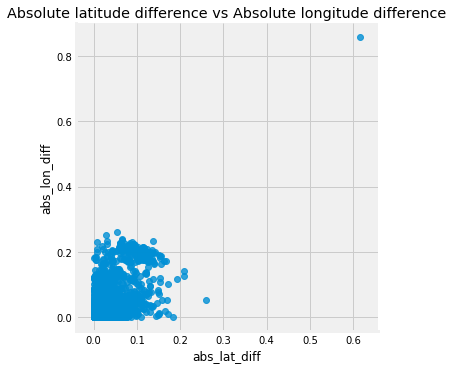

In [23]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False,
           data = clean_data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

Are there any instances where both absolute differences are 0?

In [24]:
no_diff = clean_data[(clean_data['abs_lat_diff'] == 0 ) & (clean_data['abs_lon_diff'] == 0)]
no_diff.shape

(51038, 11)

as noted in the example, why are there 51k rides with no change in lat and long?

Remake the plot above colored by the fare-bin:

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Absolute latitude difference vs. Absolute longitude difference')

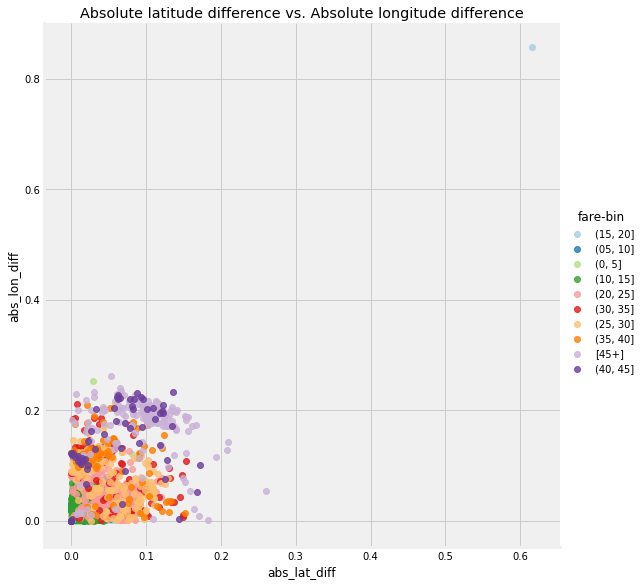

In [25]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue='fare-bin', size=8, palette=palette,
           fit_reg=False, data=clean_data.sample(10000, random_state=RSEED))
plt.title('Absolute latitude difference vs. Absolute longitude difference')

zoom in a bit

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


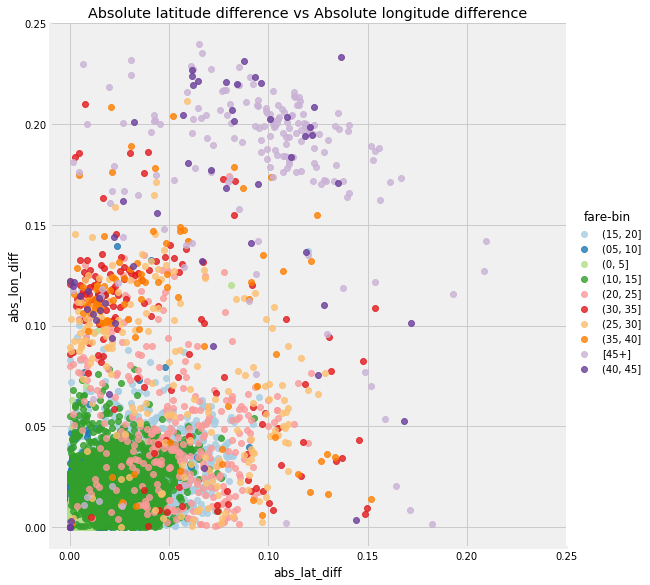

In [26]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette = palette,
           fit_reg = False, data = clean_data.sample(10000, random_state=RSEED));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

# Add Manhattan and Euclidean Distance as features

In [27]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


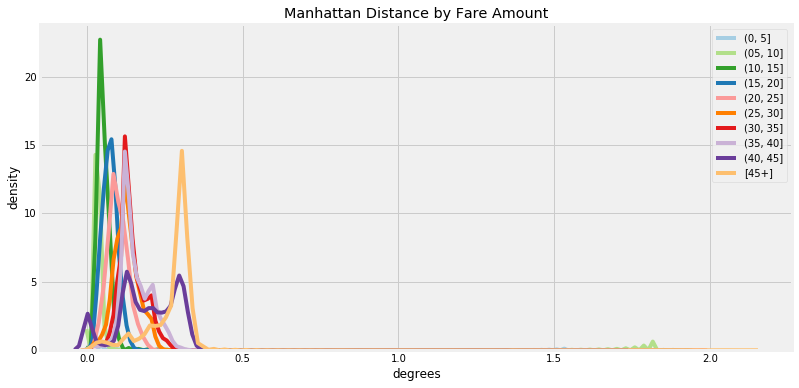

In [28]:
clean_data['manhattan'] = minkowski_distance(clean_data['pickup_longitude'], clean_data['dropoff_longitude'],
                                             clean_data['pickup_latitude'], clean_data['dropoff_latitude'], 1)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in clean_data.groupby('fare-bin'):
    sns.kdeplot(grouped['manhattan'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Manhattan Distance by Fare Amount');

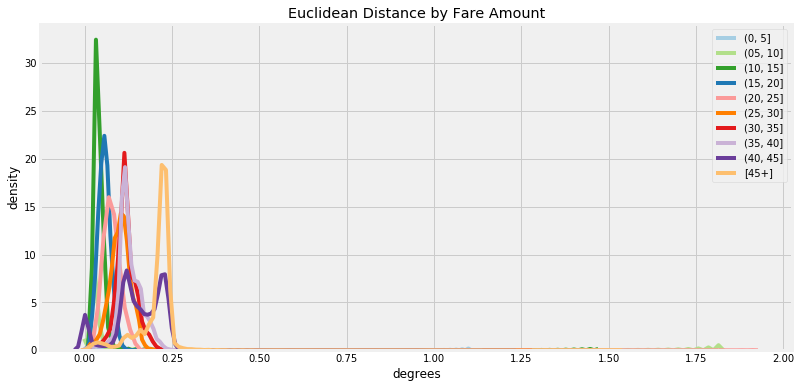

In [29]:
clean_data['euclidean'] = minkowski_distance(clean_data['pickup_longitude'], clean_data['dropoff_longitude'],
                                             clean_data['pickup_latitude'], clean_data['dropoff_latitude'], 2)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in clean_data.groupby('fare-bin'):
    sns.kdeplot(grouped['euclidean'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');


In [30]:
clean_data.groupby('fare-bin')['euclidean'].agg(['mean', 'count'])

mean    count
fare-bin               
(0, 5]   0.009   746458
(05, 10] 0.020  2251733
(10, 15] 0.037   955561
(15, 20] 0.055   350005
(20, 25] 0.076   151266
(25, 30] 0.101    94823
(30, 35] 0.117    69449
(35, 40] 0.128    40174
(40, 45] 0.153    33314
[45+]    0.191    96263

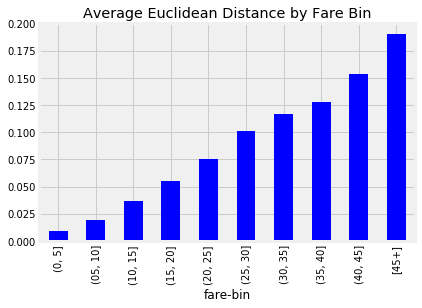

In [31]:
clean_data.groupby('fare-bin')['euclidean'].mean().plot.bar(color = 'b');
plt.title('Average Euclidean Distance by Fare Bin');

This appears to be a nice trend, should be a useful feature

Now for passenger count:

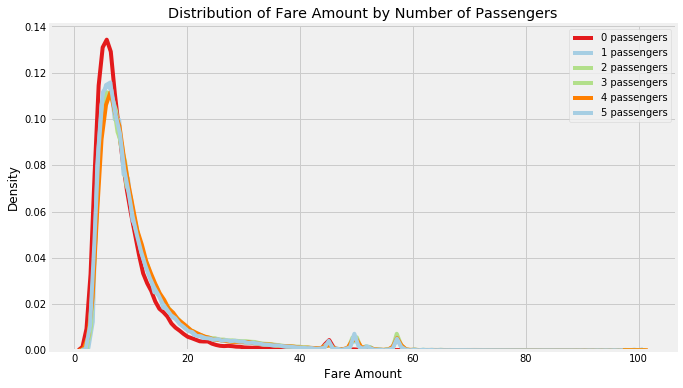

In [32]:
plt.figure(figsize = (10, 6))

for p, grouped in clean_data.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = f'{p} passengers', color = list(grouped['color'])[0]);
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

There does not appear to be much difference between the number of passengers. To get a more accurate picture, we can calculate the actual stats.

In [33]:
clean_data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

mean    count
passenger_count                
0                8.938    17215
1               11.141  3383681
2               11.762   723420
3               11.516   214778
4               11.719   103851
5               11.187   346101

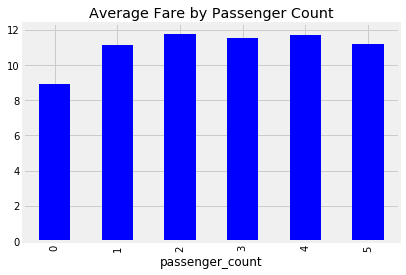

In [34]:
clean_data.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');

There is a small but noticeable difference in the average fare by the number of passengers.

# Read in test data and create same features

Before we forget, we need to read in the test data and create the same features. The test data must have the same exact features as the training data used in the model.
We can't exclude any of the test data based on outliers, and we also shouldn't use the test data for filtering outliers in the training data. The test data should ideally only be used a single time, to test the performance of a trained model.

For the test data, we need to save the key column for making submissions.

In [35]:
test = pd.read_csv('input/test.csv', parse_dates = ['pickup_datetime'])

# Create absolute differences
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

test.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count          9914.000         9914.000           9914.000          9914.000   
mean            -73.975           40.751            -73.974            40.752   
std               0.043            0.034              0.039             0.035   
min             -74.252           40.573            -74.263            40.569   
25%             -73.993           40.736            -73.991            40.735   
50%             -73.982           40.753            -73.980            40.754   
75%             -73.968           40.767            -73.964            40.769   
max             -72.987           41.710            -72.991            41.697   

       passenger_count  abs_lat_diff  abs_lon_diff  
count         9914.000      9914.000      9914.000  
mean             1.671         0.022         0.023  
std              1.279         0.026         0.037  
min              1.000         0.000         0.000  
25%              1.000         0.007         0.006  
50%              1.000         0.015         0.013  
75%              2.000         0.028         0.025  
max              6.000         0.633         0.849

**Note: The above is relatively fast, so won't save separately**

In [36]:
test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

## Add function for Haversine (great circle) distance

In [37]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [38]:
clean_data['haversine'] =  haversine_np(clean_data['pickup_longitude'], clean_data['pickup_latitude'],
                                        clean_data['dropoff_longitude'], clean_data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                                 test['dropoff_longitude'], test['dropoff_latitude'])

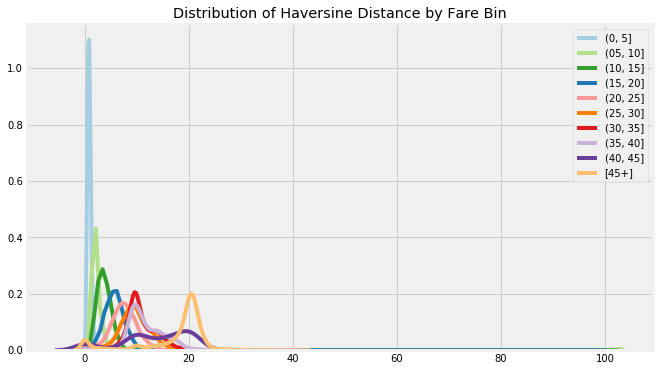

In [39]:
subset = clean_data.sample(100000, random_state=RSEED)

plt.figure(figsize = (10, 6))

for f, grouped in subset.groupby('fare-bin'):
    sns.kdeplot(grouped['haversine'], label = f'{f}', color = list(grouped['color'])[0]);
    
plt.title('Distribution of Haversine Distance by Fare Bin');

It looks like perhaps this distance will be "better" than Manhattan/Euclidean

In [40]:
clean_data.groupby('fare-bin')['haversine'].agg(['mean', 'count'])

mean    count
fare-bin                
(0, 5]    0.912   746458
(05, 10]  1.934  2251733
(10, 15]  3.701   955561
(15, 20]  5.574   350005
(20, 25]  7.522   151266
(25, 30]  9.512    94823
(30, 35] 10.727    69449
(35, 40] 11.624    40174
(40, 45] 13.952    33314
[45+]    17.490    96263

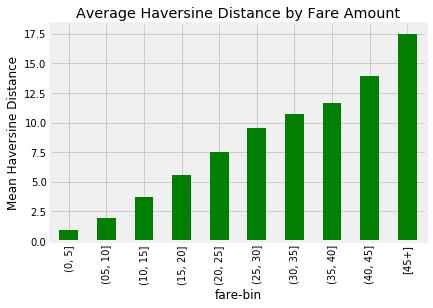

In [41]:
clean_data.groupby('fare-bin')['haversine'].mean().sort_index().plot.bar(color = 'g');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

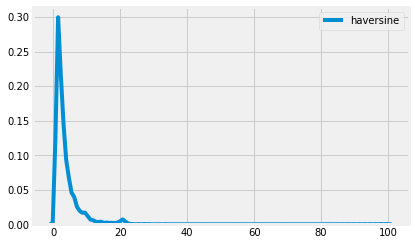

In [42]:
sns.kdeplot(test['haversine']);

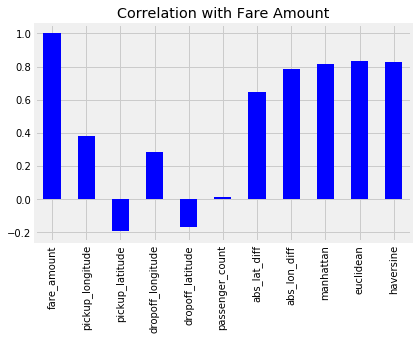

In [43]:
# I am not sure what data.corr() does?
corrs = clean_data.corr()
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');

It looks like we have a strong degree of correlation between the different distances and the fares, so perhaps a simple linear correlation would work

# Machine Learning

Now that we have built a few potentially useful features, we can use them for machine learning: training an algorithm to predict the target from the features. We'll start off with a basic model - Linear Regression - only using a few features and then move on to a more complex models and more features. There is reason to believe that for this problem, even a simple linear model will perform well because of the strong linear correlation of the distances with the fare.

**We generally want to use the simplest - and hence most interpretable - model that is above an accuracy threshold (dependent on the application) so if a linear model does the job, there's no need to use a highly complex ensemble model.** It's a best practice to start out with a simple model for just this reason!

## First Model: Linear Regression

The first model we'll make is a simple linear regression using 3 features:
- abs_lat_diff
- abs_lon_diff
- passenger_count.
This is meant to serve as a baseline for us to beat.

It's good to start with a simple model because it will give you a baseline. Also, if a simple model works well enough, then there may be no need for more complex models. If a linear regression will get the job done, then you don't need a neural network!

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

# Create Training and Validation Set

We'll want to create a training and separate validation set to assess our model. Ideally, we only use the test set once, to evaluate the final model. We can make a validation set with 1 million observations to estimate our performance.

We **stratify** the split using the `fare-bin`. This ensures that the training and validation set have the same distribution of fare bins. This is important for imbalanced classification problems, but it can also be useful for regression problems so we don't end up with a lot of outliers in terms of the target in either the validation or training set. (We have to stratify based on a discrete variable which is why we use the fare bin.)

In [45]:
# Split data
# train_test_split comes from sklearn
X_train, X_valid, y_train, y_valid = train_test_split(clean_data, np.array(clean_data['fare_amount']), 
                                                      stratify = clean_data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

## Train with Simple Features

We'll train the linear regression using three features. The benefit of the linear regression is that it's interpretable: we can inspect the coefficients and intercept.

In [46]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4),
      '\tpassenger_count coef:', round(lr.coef_[2], 4))

Intercept 5.0751
abs_lat_diff coef:  114.0374 	abs_lon_diff coef: 163.9525 	passenger_count coef: 0.0196


In all cases, the coefficient is positive, indicating a larger value of the variable corresponds to a larger fare according to the model. We can say that according to a linear model, for every 1 more passenger, the fare increases by \\$0.02. The intercept indicates the fare that would be predicted if there is no latitude or longitude difference and the passenger count is 0

### Score Model

Here we use the validation set for assessing the model. We'll use two metrics:
- Root mean squared error: the metric used by the competition
- Mean absolute percentage error: the average percentage error of the predictions

I like using the mean absolute percentage error (MAPE) because it's often more interpretable.

In [47]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [48]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.34 	 mape = 28.15
Validation: rmse = 5.33 	 mape = 28.1


**Without anything to compare these results to, we can't say if they are good. This is the reason for establishing a basic baseline with no machine learning!**

## Naive Baseline

To make sure that machine learning is even applicable to the task, we should compare these predictions to a naive guess. For a regression task, this can be as simple as the average value of the target in the training data.

In [49]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.35 	 mape = 64.81
Baseline Validation: rmse = 9.35 	 mape = 64.76


According to the naive baseline, our machine learning solution is effective! We are able to reduce the percentage error by about half and generate much better predictions than using no machine learning. This should give us confidence we are on the right track.

## Make a submission

**This is for Kaggle submissions**

In order to make a submission to Kaggle, we have to make predictions on the test data. Below we make the predictions and save them to a csv file in the format specified by the competition

In [50]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr_simple.csv', index = False)

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


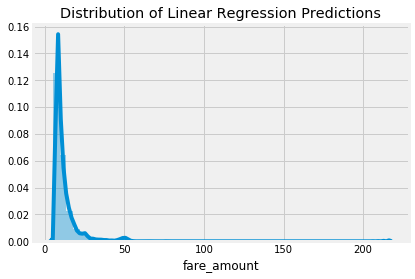

In [51]:
sns.distplot(sub['fare_amount'])
plt.title('Distribution of Linear Regression Predictions');

Look at the predictions over \$100 (these will be most damaging to the Kaggle score)

In [52]:
test.loc[sub[sub['fare_amount'] > 100].index]

pickup_datetime  pickup_longitude  pickup_latitude  \
4080 2010-06-11 13:37:21           -73.137           41.366   
5887 2010-07-04 16:44:11           -73.137           41.366   
8529 2009-11-25 19:32:52           -73.137           41.366   

      dropoff_longitude  dropoff_latitude  passenger_count  abs_lat_diff  \
4080            -73.984            40.733                1         0.633   
5887            -73.983            40.767                1         0.599   
8529            -73.987            40.758                3         0.608   

      abs_lon_diff  manhattan  euclidean  haversine  
4080         0.847      1.480      1.057    100.106  
5887         0.845      1.444      1.036     97.348  
8529         0.849      1.457      1.044     98.300

In [53]:
sub[sub['fare_amount'] > 100]

key  fare_amount
4080  2010-06-11 13:37:21.0000004      216.132
5887  2010-07-04 16:44:11.0000002      211.970
8529  2009-11-25 19:32:52.0000001      213.711

We will want to compare these to the other models later:

In [54]:
simple_over_100 = list(sub[sub['fare_amount'] > 100].index)
sub['fare_amount'].describe()

count   9914.000
mean      11.460
std        8.118
min        5.095
25%        7.444
50%        9.078
75%       12.332
max      216.132
Name: fare_amount, dtype: float64

As a linear model, the linear regression is not flexible at all. In other words, it has a high bias because it assumes a linear relationship between the predictor variables (features) and the response (target). The final formula produced by the model is interpretable, but that doesn't mean it's right! In machine learning, we often have to make a tradeoff between model interpretability and model accuracy. In this case the linear regression does well, but as we'll see, a more complex model does even better.

# Use More Features

While the first model scored well relative to the baseline, there is much room for improvement. As a first step, let's use one of the other features we created, the haversine distance.

**Note: This is still linear**

In [55]:
lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.02 	 mape = 24.62
Validation: rmse = 5.03 	 mape = 24.58


In [56]:
print(lr.intercept_)
print(lr.coef_)

4.558339829301004
[ 4.32099914e+00 -2.46151626e+02 -1.07563524e+02  1.19585161e-02]


Using this one more feature improved our score slightly. Here's another chance for improvement using the same model:
- Potential Improvement 3: find an optimal set of features or construct more features. This can involve feature selection or trying different combinations of features and evaluating them on the validation data. You can build additional features by looking at others' work or researching the problem.

## Collinear Features

One thing we do want to be careful about is highly correlated, known as collinear, features. These can decrease the generalization performance of the model and lead to less interpretable models. Many of our features are already highly correlated as shown in the heatmap below. This plots the Pearson Correlation Coefficient for each pair of variables.

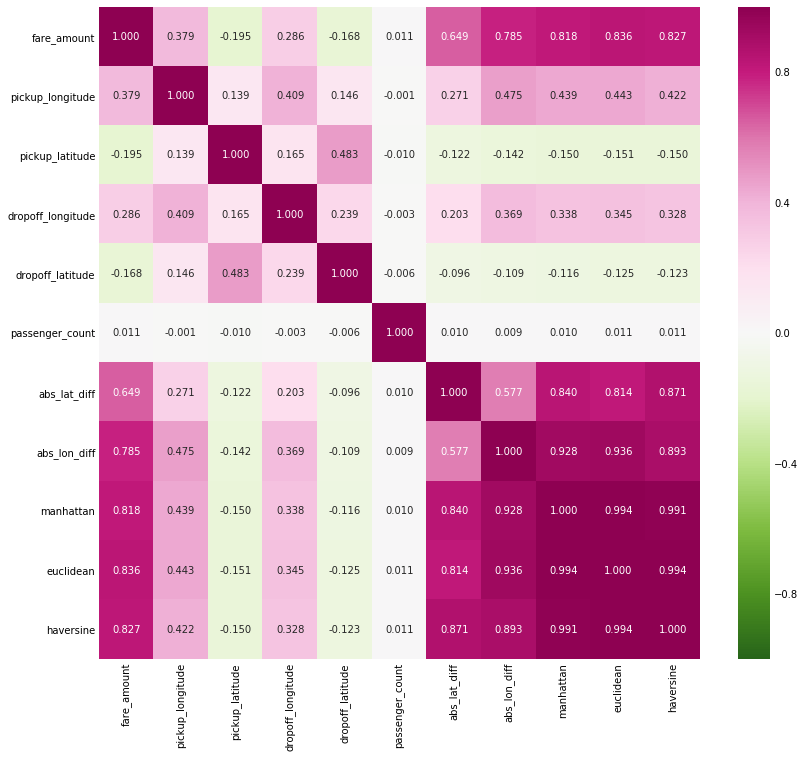

In [57]:
corrs = clean_data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

**Note: You might not want to use two variables that are very highly correlated with each other (such as euclidean and haversine) because of issues with interpretability and performance.**

## Upgraded Model

When we want to improve performance, we generally have a few options:

- Get more data - either more observations or more variables
- Engineer more / better features
- Perform feature selection to remove irrelevant features
- Try a more complex model
- Perform hyperparameter tuning of the selected model

We already saw that including another feature could improve perfomance. For now let's move past the features and focus on the model (we'll come back to features later).

The simple linear regression has no hyperparameters to optimize (no settings to tune) so we'll try approach 4. If the more complex model does well, we can use it for testing additional features or performing feature selection

### Non-Linear Model: Random Forest

**WHY RANDOM FOREST AND NOT SOMETHING ELSE?**

For a first non-linear model, we'll use the Random Forest regressor. This is a powerful ensemble of regression trees that has good performance and generalization ability because of its low variance. We'll use most of the default hyperparameters but change the n_estimators and the max_depth of each tree in the forest. For the features, we'll use the four features which delivered good performance in the linear regression.

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  1.1min remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished
/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [59]:
evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    4.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    4.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Training:   rmse = 3.56 	 mape = 20.39
Validation: rmse = 4.19 	 mape = 22.03


[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    1.4s finished


The random forest does much better than the simple linear regression. **This indicates that the problem is not completely linear, or at least is not linear in terms of the features we have constructed.** From here going forward, we'll use the same random forest model because of the increased performance.

## Overfitting

**Given the gap between the training and the validation score, we can see that our model is overfitting to the training data.** This is one of the most common problems in machine learning and is usually addressed either by training with more data, or adjusting the hyperparameters of the model. This leads to another recommendation for improvement:

**Potential Improvement 4: Try searching for better random forest model hyperparameters. You may find Scikit-Learn's RandomizedSearchCV a useful tool.**

I'll provide some starter code for hyperparameter optimization later in the notebook.
Next we can make predictions with the random forest for uploading to the competition.

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished
/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


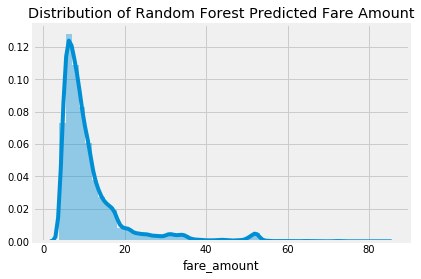

In [60]:
preds = random_forest.predict(test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predicted Fare Amount');

Compare to the linear model:

In [61]:
## sub is now the random forest model
sub.loc[simple_over_100]

key  fare_amount
4080  2010-06-11 13:37:21.0000004        8.191
5887  2010-07-04 16:44:11.0000002        8.624
8529  2009-11-25 19:32:52.0000001       11.779

Wow! The random forest and the linear regression significantly disagree. This brings up another point: one option we have for modeling is to combine the predictions of multiple models. Oftentimes, averaging the predictions of multiple models will result in better performance than either model by itself. Just for fun, let's try averaging the validation predictions of both models.

## Average Models

We'll assess the validation performance of a simple averaging of the linear regression and random forest.

In [62]:
lr_tpred = lr.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
rf_tpred = random_forest.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

lr_pred = lr.predict(X_valid[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
rf_pred = random_forest.predict(X_valid[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

# Average predictions
train_pred = (lr_tpred + rf_tpred) / 2
valid_pred = (lr_pred + rf_pred) / 2

tr, vr, tm, vm = metrics(train_pred, valid_pred, y_train, y_valid)

print(f'Combined Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Combined Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    4.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    4.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Combined Training:   rmse = 4.08 	 mape = 22.01
Combined Validation: rmse = 4.38 	 mape = 22.78


[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    1.4s finished


**For this problem, the random forest by itself is slightly better. However, I'd encourage you to experiment with a range of models given that the best model depends on the dataset.**

# More Features

Now that we've decided on the Random Forest as our model, we can try using additional features. Let's see what happens when we use 8 of the features for training. The function below trains the random forest and assesses it on the validation data.

In [63]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 20, max_depth = 20,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    if return_model:
        return sub, feature_importances, model
    
    return sub, feature_importances

In [64]:
clean_data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'color', 'abs_lat_diff', 'abs_lon_diff', 'manhattan', 'euclidean',
       'haversine'],
      dtype='object')

In [65]:
# Evaluate using all 8 "location" or "spatial" features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

Training:   rmse = 3.06 	 mape = 18.31
Validation: rmse = 3.71 	 mape = 19.92


Let's see which features the model thinks are important

**Note: it appears that feature importance will be framework dependent, and it will be important to investigate what features are available in different frameworks**

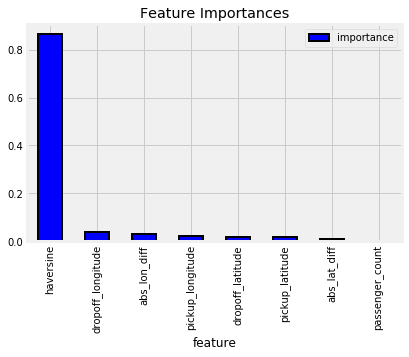

In [66]:
fi.plot.bar(color = 'b', edgecolor = 'k', linewidth = 2);
plt.title('Feature Importances');

The haversine distance is by far the most important with the other features showing considerably less relevance to the model. This suggests that distance is key, and we might want to find a more accurate way of calculating distances.

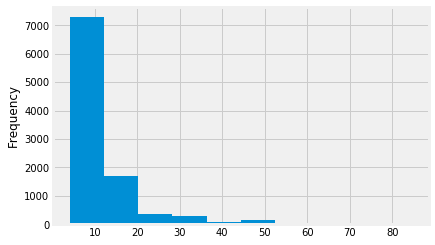

In [67]:
sub.to_csv('sub_rf_8_features.csv', index = False)
sub['fare_amount'].plot.hist();

Let's add dateime information:

In [68]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [69]:
print(clean_data['pickup_datetime'].min())
print(test['pickup_datetime'].min())

2009-01-01 00:00:46
2009-01-01 11:04:24


In [70]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.head()

pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0 2015-01-27 13:08:24           -73.973           40.764            -73.981   
1 2015-01-27 13:08:24           -73.987           40.719            -73.999   
2 2011-10-08 11:53:44           -73.983           40.751            -73.980   
3 2012-12-01 21:12:12           -73.981           40.768            -73.990   
4 2012-12-01 21:12:12           -73.966           40.790            -73.989   

   dropoff_latitude  passenger_count  abs_lat_diff  abs_lon_diff  manhattan  \
0            40.744                1         0.020         0.008      0.028   
1            40.739                1         0.020         0.012      0.032   
2            40.746                1         0.005         0.003      0.008   
3            40.752                1         0.016         0.009      0.025   
4            40.744                1         0.045         0.023      0.068   

   euclidean       ...        pickup_is_leap_year  pickup_Hour  pickup_Minute  \
0      0.022       ...                      False           13              8   
1      0.023       ...                      False           13              8   
2      0.006       ...                      False           11             53   
3      0.019       ...                       True           21             12   
4      0.051       ...                       True           21             12   

   pickup_Second  pickup_Days_in_year  pickup_frac_day  pickup_frac_week  \
0             24                  365            0.547             0.221   
1             24                  365            0.547             0.221   
2             44                  365            0.496             0.785   
3             12                  366            0.883             0.840   
4             12                  366            0.883             0.840   

   pickup_frac_month  pickup_frac_year  pickup_Elapsed  
0              0.861             0.075   191596058.000  
1              0.861             0.075   191596058.000  
2              0.265             0.769    87306778.000  
3              0.059             0.918   123628286.000  
4              0.059             0.918   123628286.000  

[5 rows x 28 columns]

In [71]:
clean_data = extract_dateinfo(clean_data, 'pickup_datetime', drop = False,
                              time = True, start_ref = data['pickup_datetime'].min())
test.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count          9914.000         9914.000           9914.000          9914.000   
mean            -73.975           40.751            -73.974            40.752   
std               0.043            0.034              0.039             0.035   
min             -74.252           40.573            -74.263            40.569   
25%             -73.993           40.736            -73.991            40.735   
50%             -73.982           40.753            -73.980            40.754   
75%             -73.968           40.767            -73.964            40.769   
max             -72.987           41.710            -72.991            41.697   

       passenger_count  abs_lat_diff  abs_lon_diff  manhattan  euclidean  \
count         9914.000      9914.000      9914.000   9914.000   9914.000   
mean             1.671         0.022         0.023      0.045      0.035   
std              1.279         0.026         0.037      0.056      0.042   
min              1.000         0.000         0.000      0.000      0.000   
25%              1.000         0.007         0.006      0.017      0.013   
50%              1.000         0.015         0.013      0.029      0.022   
75%              2.000         0.028         0.025      0.053      0.040   
max              6.000         0.633         0.849      1.480      1.057   

       haversine       ...        pickup_Days_in_month  pickup_Hour  \
count   9914.000       ...                    9914.000     9914.000   
mean       3.439       ...                      30.469       13.467   
std        3.977       ...                       0.703        6.869   
min        0.000       ...                      28.000        0.000   
25%        1.300       ...                      30.000        8.000   
50%        2.220       ...                      31.000       15.000   
75%        4.050       ...                      31.000       19.000   
max      100.106       ...                      31.000       23.000   

       pickup_Minute  pickup_Second  pickup_Days_in_year  pickup_frac_day  \
count       9914.000       9914.000             9914.000         9914.000   
mean          29.548         16.611              365.145            0.582   
std           18.675         19.571                0.352            0.286   
min            0.000          0.000              365.000            0.000   
25%           13.000          0.000              365.000            0.356   
50%           33.000          6.000              365.000            0.627   
75%           45.000         33.000              365.000            0.827   
max           59.000         59.000              366.000            0.999   

       pickup_frac_week  pickup_frac_month  pickup_frac_year  pickup_Elapsed  
count          9914.000           9914.000          9914.000        9914.000  
mean              0.491              0.534             0.531   105528198.549  
std               0.283              0.282             0.278    55864049.590  
min               0.000              0.032             0.003       39818.000  
25%               0.273              0.291             0.315    59252977.000  
50%               0.473              0.541             0.533    96795134.000  
75%               0.727              0.805             0.758   158694421.000  
max               1.000              0.999             0.999   204926584.000  

[8 rows x 26 columns]

Look into the data

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


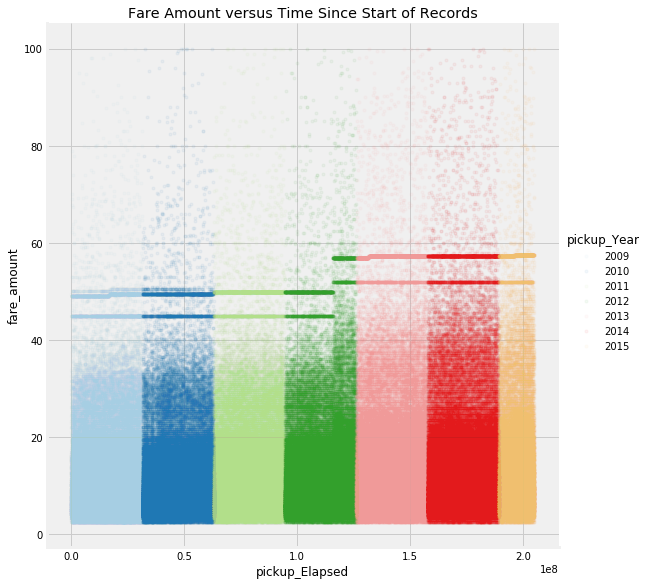

In [72]:
sns.lmplot('pickup_Elapsed', 'fare_amount', hue = 'pickup_Year', palette=palette, size = 8,
           scatter_kws= {'alpha': 0.05}, markers = '.', fit_reg = False,
           data = clean_data.sample(1000000, random_state=RSEED));
plt.title('Fare Amount versus Time Since Start of Records');

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


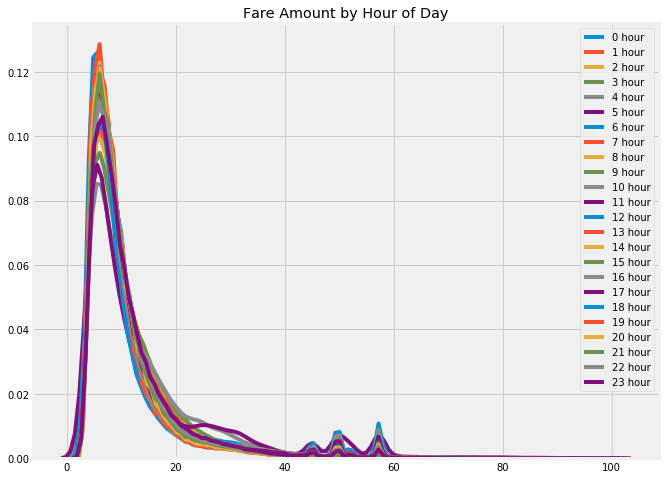

In [73]:
plt.figure(figsize = (10, 8))
for h, grouped in clean_data.groupby('pickup_Hour'):
    sns.kdeplot(grouped['fare_amount'], label = f'{h} hour');
plt.title('Fare Amount by Hour of Day');

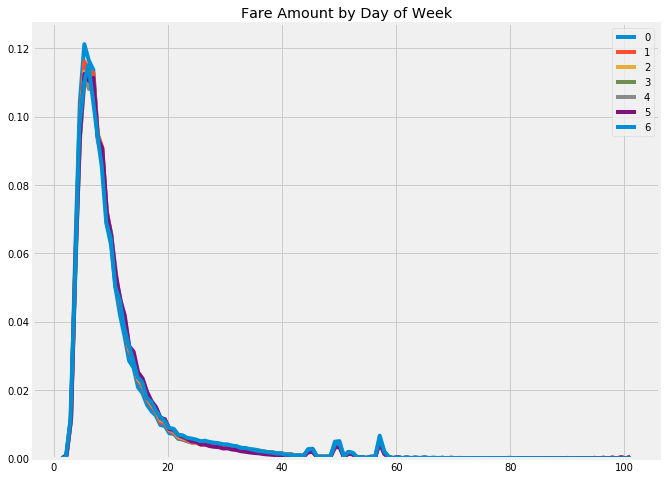

In [74]:
plt.figure(figsize = (10, 8))
for d, grouped in clean_data.groupby('pickup_Dayofweek'):
    sns.kdeplot(grouped['fare_amount'], label = f'{d}')
plt.title('Fare Amount by Day of Week');

Now look at the fractional time data

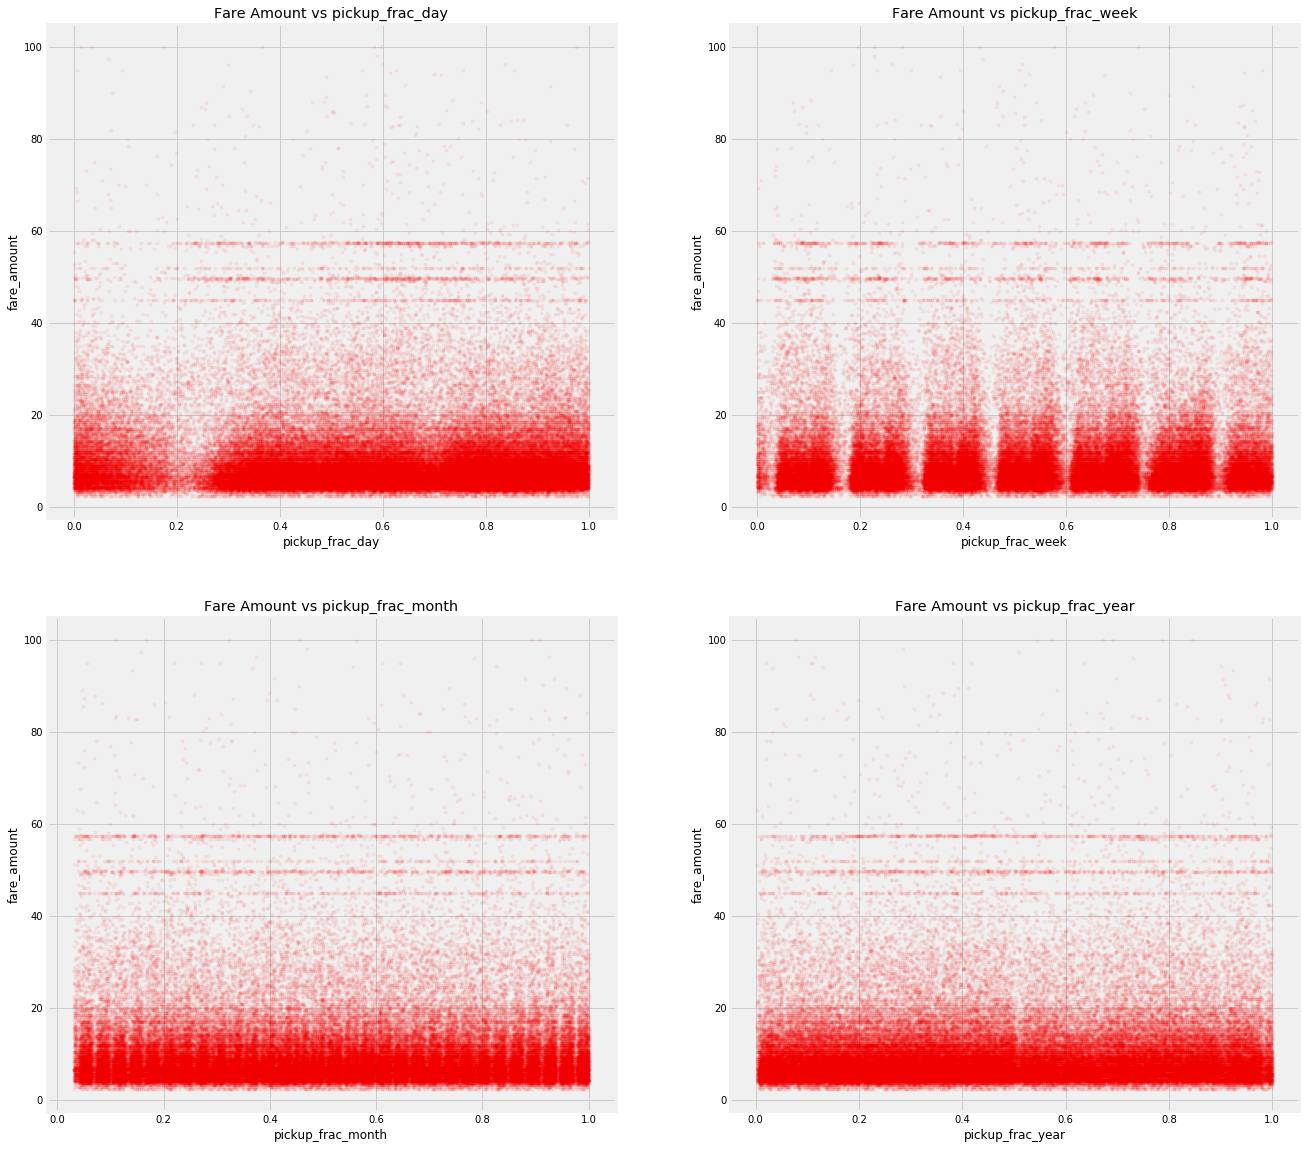

In [75]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))
axes = axes.flatten()

# Plot each of the fractional times
for i, d in enumerate(['day', 'week', 'month', 'year']):
    ax = axes[i]
    sns.regplot(f'pickup_frac_{d}', 'fare_amount', 
                data = clean_data.sample(100000, random_state = RSEED), 
                fit_reg = False, scatter_kws = {'alpha': 0.05}, marker = '.', ax = ax,
                color = 'r')
    
    ax.set_title(f'Fare Amount vs pickup_frac_{d}')

While there aren't terribly clear trends, the horizontal lines are intriguing...

In [76]:
fare_counts = clean_data.groupby('fare_amount')['haversine'].agg(['count', pd.Series.nunique]).sort_values('count', ascending = False)
fare_counts.head()

count    nunique
fare_amount                   
6.500        233020 230678.000
4.500        197301 194350.000
8.500        179632 178165.000
5.300        141874 139923.000
5.700        141812 140038.000

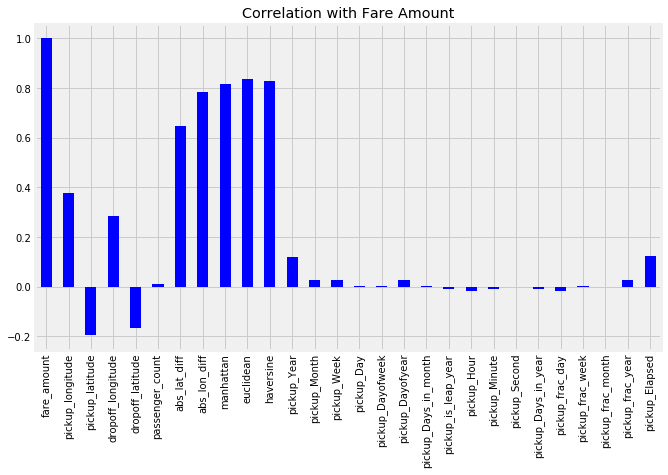

In [77]:
corrs = clean_data.corr()
corrs['fare_amount'].plot.bar(color = 'b', figsize = (10, 6));
plt.title('Correlation with Fare Amount');

While not nearly as highly correlated as distance, there are indeed some time trends that correlate

In [78]:
# resplit the data
X_train, X_valid, y_train, y_valid = train_test_split(clean_data, np.array(clean_data['fare_amount']), 
                                                      stratify = clean_data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

In [79]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

In [80]:
# Test using the features
sub, fi, random_forest = model_rf(X_train, X_valid, y_train, y_valid, test, 
                                  features = features, return_model=True)

Training:   rmse = 2.61 	 mape = 15.36
Validation: rmse = 3.38 	 mape = 17.16


In [81]:
lr = LinearRegression()

# Fit and evaluate
lr.fit(X_train[features], y_train)
evaluate(lr, features, X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.87 	 mape = 23.93
Validation: rmse = 4.88 	 mape = 23.87


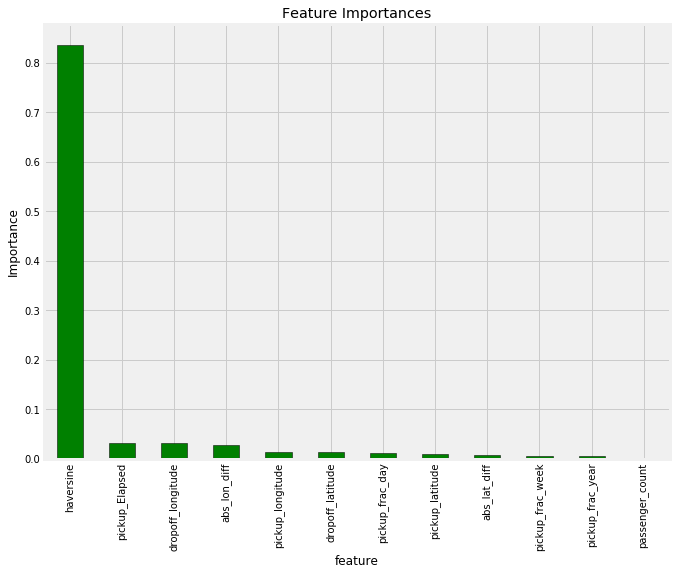

In [82]:
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [83]:
# Save submission
sub.to_csv('sub_rf_frac_time.csv', index = False)

Use known data to check the performance

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


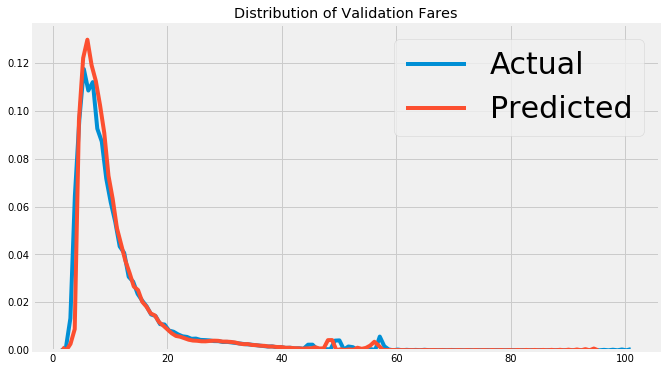

In [84]:
valid_preds = random_forest.predict(X_valid[features])

plt.figure(figsize = (10, 6))
sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(valid_preds, label = 'Predicted')
plt.legend(prop = {'size': 30})
plt.title("Distribution of Validation Fares");

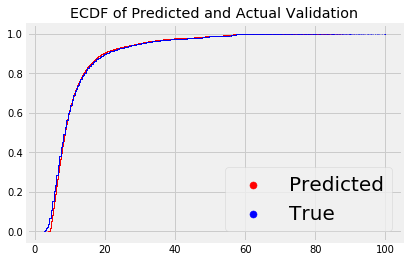

In [85]:
# Generate ecdf data
xv, yv = ecdf(valid_preds)
xtrue, ytrue = ecdf(y_valid)

# Plot the ecdfs on same plot
plt.scatter(xv, yv, s = 0.02,  c = 'r', marker = '.', label = 'Predicted')
plt.scatter(xtrue, ytrue, s = 0.02, c = 'b', marker = '.', label = 'True')
plt.title('ECDF of Predicted and Actual Validation')

plt.legend(markerscale = 100, prop = {'size': 20});

In [86]:
analyze = pd.DataFrame({'predicted': valid_preds, 'actual': y_valid})
analyze.describe()

predicted      actual
count 1000000.000 1000000.000
mean       11.263      11.261
std         8.730       9.347
min         2.550       2.500
25%         6.329       6.000
50%         8.551       8.500
75%        12.412      12.500
max        94.329     100.000

# Hyperparameter Tuning

With the random forest, there are a ton of model hyperparamters to optimize. The process of hyperparameter optimization means finding the best hyperparameters for an algorithm on a specific dataset. The ideal values changes across data sets so we have to perform this step on every new dataset. I like to think of hyperparameter optimization as finding the best settings for a machine learning model.

## Random Search

We'll use a basic form of hyperparameter tuning, random search. This means constructing a parameter grid and then randomly selecting combinations of values, evaluating them in cross validation, and determining which combination performs the best. This is quickly done using the RandomizedSearchCV in Scikit-Learn.
The following code sets up the search. Feel free to play around with the param_grid.

In [87]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'neg_mean_absolute_error', cv = 3, 
                        n_iter = 100, verbose = 1, random_state=RSEED)

Because this search is expensive, use a small sample set

In [88]:
tune_data = clean_data.sample(100_000, random_state = RSEED)

# Select features
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

rs.fit(tune_data[features], np.array(tune_data['fare_amount']))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94, ...9, 49, 49, 49, 49, 49, 49, 49, 49, 50], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=100, re

In [89]:
model = rs.best_estimator_
print(f'The best parameters were {rs.best_params_} with a negative mae of {rs.best_score_}')

The best parameters were {'n_estimators': 41, 'min_samples_split': 2, 'max_leaf_nodes': 49, 'max_features': 0.5, 'max_depth': 22, 'bootstrap': True} with a negative mae of -2.0216735083205952


In [90]:
model.n_jobs = -1
model.fit(X_train[features], y_train)

evaluate(model, features, X_train, X_valid, y_train, y_valid)

Training:   rmse = 3.76 	 mape = 21.03
Validation: rmse = 3.77 	 mape = 21.0


This appears to require more data for a better fit...

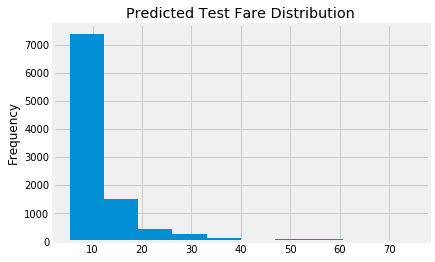

In [91]:
pred = np.array(model.predict(test[features])).reshape((-1))
sub = pd.DataFrame({'key': test_id, 'fare_amount': pred})
sub.to_csv('sub_rf_tuned.csv', index = False)
sub['fare_amount'].plot.hist();
plt.title('Predicted Test Fare Distribution');

Next Steps:

- Try to train using Keras Neural Nets
    - Look at Matthew's example for how to set that up
- Also put this stuff into a MongoDB to play around with